# **Lab session 2 :**
## **Exercise 4 : MBE skin cancer classification using a CNN**

In this session you will develop a CNN to classify images of skin cancer into 7 categories.

The images come from the **HAM10000 ("Human Against Machine with 10000 training images")** dataset. It consists of 10015 dermatoscopic images which are released as a training set for academic machine learning purposes and are publicly available through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts. 

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**

We will follow these steps to classify moles into 7 classes.

**Step 1: Importing Essential Libraries**<br>
**Step 2: Making Dictionary of images and labels** <br>
**Step 3: Reading and Processing Data** <br>
**Step 4: Data Cleaning** <br>
**Step 5: Exploratory data analysis (EDA)** <br>
**Step 6: Loading & Resizing of images** <br>
**Step 7: Train Test Split**<br>
**Step 8: Normalization**<br>
**Step 9: Label Encoding** <br>
**Step 10: Train validation split** <br>
**Step 11: Model Building (CNN)** <br>
**Step 12: Setting Optimizer & Annealing** <br>
**Step 13: Fitting the model**<br>
**Step 14: Model Evaluation (Testing and validation accuracy, confusion matrix, analysis of misclassified instances)** <br>


# Step 1 : Auxiliary steps

 importing essential python libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, requests, tarfile, io, itertools
from PIL import Image
from time import time
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import tensorflow as tf
print (tf.__version__)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi


2.4.0
Found GPU at: /device:GPU:0
Fri Dec 18 16:37:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |    227MiB / 15079MiB |      8%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                      

Your data will be stored in your google drive space. You need to mount your drive to access it from the notebook. You will be invited to confirm authorization in a separate window and copy&paste authorization code.

In [2]:
# -*- coding: utf-8 -*-
"""exercise_3_functions.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1ou7s5cH5IcIYnpCQBsMBMvDxF3qRb4AY
"""

from matplotlib import pyplot as plt
import numpy as np
import itertools

# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



#define a function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_accuracy'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/My Drive/Colab Notebooks/MBE DL course'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass

sys.path.append(base_working_dir)

base_working_dir = os.path.join(base_working_dir, 'Skin_Cancer_class')

if not os.path.exists(base_working_dir):
    os.makedirs(base_working_dir)
    
print (base_working_dir)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/MBE DL course/Skin_Cancer_class


# Step 2 : Making Dictionary of labels

In [4]:
# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

# Step 3 : Reading & Processing data

We made some new columns which is easily understood for later reference such as the path to the image_id, cell_type which contains the short name of lesion type. 

We convert the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [5]:
try:
    skin_df = pd.read_csv(os.path.join(base_working_dir, 'HAM10000_metadata.csv'))
except:
    # download images from a shared archive 
    url = 'https://drive.google.com/uc?authuser=0&id=1jdCVOmeJXI6bhWIfFVL7RqwyuOHiRjaE&export=download'
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(base_working_dir, 'HAM10000_metadata.csv'), 'wb').write(r.content)
    skin_df = pd.read_csv(os.path.join(base_working_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

Execute the cell below and look on the table. We have a table where each line references image and corresponding data (localization, lesion, consensus, sex, ...). Use this table to analyze distribution of various variables here.

In [6]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


# Step 5 : Statistical Analysis of the Data

Look at different features of the **HAM10000_metadata.csv** dataset, their distributions and counts.<br>
Use the method **value_counts()** of the pandas datasheet **skin_df** to plot the following distributions:
1. the type of the cancer 
2. the validation method used 
3. the location of the cancer on the body
4. the age
5. the sex
6. the prevalence of each cancer type against the age. Use the **scatterplot** function from the **seaborn** package. 



### **Q : What is the most frequently occuring cancer type in the database?**

plot the histogram of the 'cell_type' occurences. Use the **value_counts()** method of the pandas table 'skin_df' as indicated below.

As we can see the most common cancer type in the database is the Melanocytic nevi.


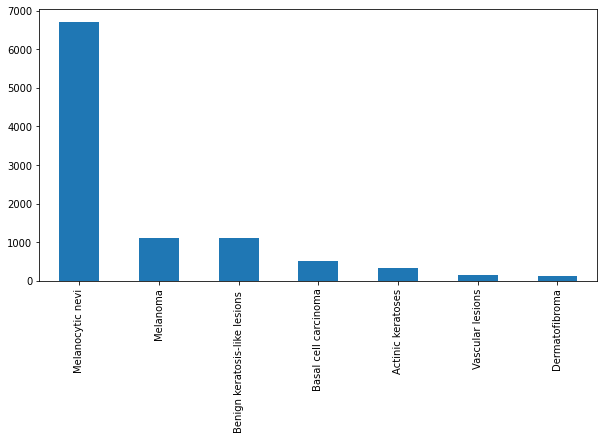

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

### **Plot the frequency of different validation methods.** <br> 
The Technical Validation has been done by either of the following methods:<br>
**1. Histopathology(Histo):**
**2. Confocal:** In-vivo reflectance confocal microscope
**3. Follow-up:** If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists  accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions. **4. Consensus:** For typical benign cases without histopathology or followup biologists provide an expert consensus (labeled consensus only if both experts independently gave the same unequivocal diagnosis.


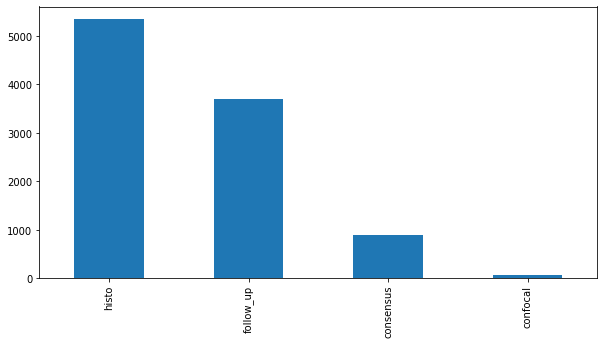

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['dx_type'].value_counts().plot(kind='bar', ax=ax1)

### **Q. What are the most heavily compromised regions of skin cancer?**

The most heavily compromised region by the skin cancer is the back.

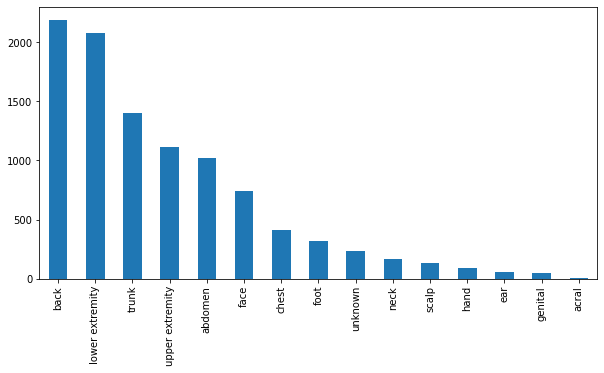

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['localization'].value_counts().plot(kind='bar', ax=ax1)

### **Q. Check the distribution of Age**

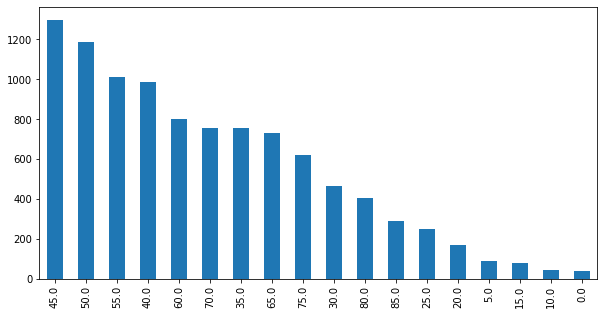

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['age'].value_counts().plot(kind='bar', ax=ax1)

### **Q. Plot the distribution of males and females.**

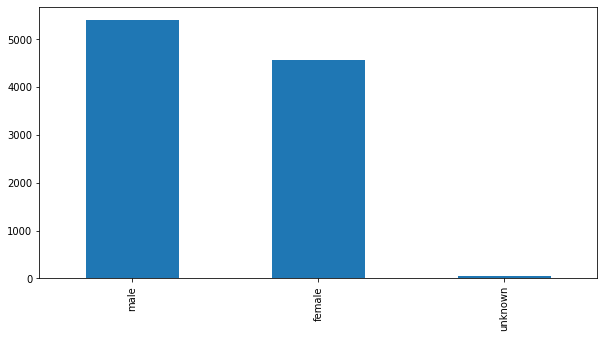

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['sex'].value_counts().plot(kind='bar', ax=ax1)

### **Q. Visualize the age-wise distribution of skin cancer types.**<br>
**What conclusions can be made about the prevalence of different cancer types regarding the age?**<br>

With have less cancer if the patient is less than 30 years old.

Use the seaborn method scatterplot.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


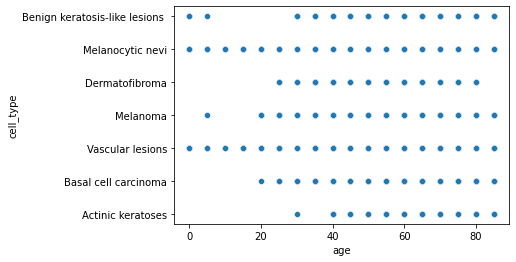

In [12]:
sns.scatterplot(skin_df['age'], skin_df['cell_type'] )

# Step 6: Loading the images

In the three following steps cancer images will be loaded from a shared archive to your personal Google Drive storage space. After this step a new file "HAM10000_images.tar" should be created in your Google Drive.

1) High-resolution images and the relief of the lesion are important featuers for dermatologists to examine visually skin moles.

2) We do not have access to the 3D relief using dermatoscopic images. 

3) Processing big data is time-costly. In this lab session we will use on downsampled images.

4) Interested in trying later on mid-sized images? Use the file 'HAM10000_images_300x225.tar' (you will need to download it manually to the Skin_Cancer_class directory in your Gdrive first). Make the model deeper. Experiment with different-size models, regularization and batch normalization. Could you obtain better accuracy?

Yes, we can obtain better accuracy by making model keeper and with regularization, batch normalization... We can always improve our results.



In [13]:
# select below to work with small images or large images

if True:   
    # use small 150x100 images first
    url = 'https://drive.google.com/uc?authuser=0&id=1--oGquD0y48lW-6WRz5ldM1rGqbJKOez&export=download'
    tgz_name = 'HAM10000_images_150x100.tar'
else:      
    # high resolution is important for dermatologists to assess skin moles visually
    # interested in training on larger images 300x250?  
    # Download this file manually to your Google drive first
    # https://drive.google.com/uc?authuser=0&id=1-4fKAGB_rpzp6eFFEzAYOVJgXtkDzLoW&export=download
    url = ''
    tgz_name = 'HAM10000_images_300x225.tar'

In [14]:
try:
    t = tarfile.open(os.path.join(base_working_dir,tgz_name), 'r')
    print ('file %s found'%os.path.join(base_working_dir,tgz_name))
except:
    # download images from a shared archive 
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(base_working_dir,tgz_name), 'wb').write(r.content)
    print ('%s downloaded'%os.path.join(base_working_dir,tgz_name))

file /content/drive/My Drive/Colab Notebooks/MBE DL course/Skin_Cancer_class/HAM10000_images_150x100.tar found


The images will be decompressed and loaded into the datasheet from the downloaded archive.  Loading 10000 images takes several seconds.

In [15]:
# read each image and assign it as a cell content
t = tarfile.open(os.path.join(base_working_dir,tgz_name), 'r')

t1 = time()
skin_df['image'] = skin_df['image_id'].map(lambda x: np.asarray(Image.open(io.BytesIO(t.extractfile(os.path.join('HAM10000_images',x+'.jpg')).read()))))
print ('%d images read in %d seconds.'%(len(skin_df['image']),time()-t1))

10015 images read in 6 seconds.


Now you have 10015 colour images of size 100x75 loaded into the computer memory.

Check a few sample images to see each cancer type

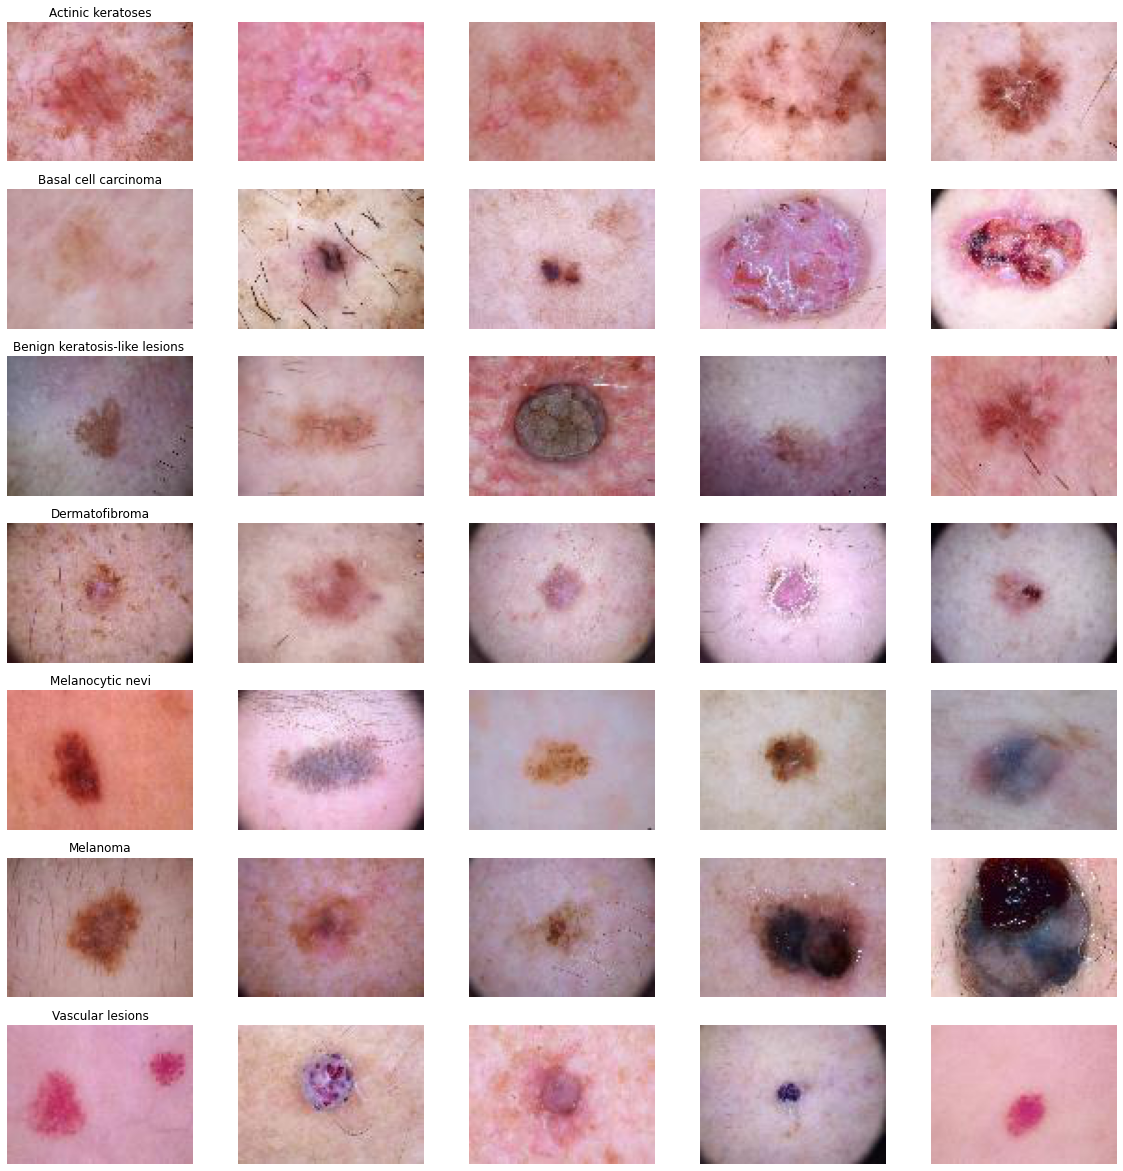

In [16]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
      c_ax.imshow(c_row['image'])
      c_ax.axis('off')

# Step 7 : Dataset preparation
Convert the target (the **cell_type_idx** column of the datasheet) into the one-hot encoding format. Recall, that one-hot encoding allows having several output neurons, with only one out of these firing one. Use the keras **to_categorical** function for the conversion.

Split the dataset into training and testing set of 80:20 ratio. The testing set will not be used during the training but rather in the end of this script to test the accuracy. The training set will be further split into training and validation. Use the scikit-learn **train_test_split** function.

In [17]:
features = np.asarray(skin_df['image'])
target = to_categorical(skin_df['cell_type_idx'], num_classes = 7)


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

# Step 8 : Normalization

If your data come from different acquisition devices (different dermatoscope devices in various labs) it is always a good idea to normalize your data. <br>
Normalize the x_train, x_test arrays by substracting the mean values and dividing by the standard deviation.

In [18]:
X_train = np.asarray(X_train.tolist())
X_test = np.asarray(X_test.tolist())

X_train_mean = np.mean(X_train)
X_test_mean = np.mean(X_test)

X_train_std = np.std(X_train)
X_test_std = np.std(X_test)

X_train = (X_train - X_train_mean)/(X_train_std)
X_test = (X_test - X_test_mean)/(X_test_std)

# Step 10 : Splitting training and validation
Split further the train set in two parts : 
1. the majority (90%) is for training the model.
2. the rest, a small fraction (10%) for validation

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

# Step 11: Model Building 
# CNN
Used the Keras **Sequential()** API to build your model. You can simply add one layer at a time, starting from the input, towards the output.

The first one is the convolutional **Conv2D()** layer. It is a set of learnable filters. 

A second important type of layer in CNN is the pooling **MaxPool2D()** layer. This layer simply acts as a downsampling filter. It is used to reduce computational cost, and to reduce overfitting.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

**Dropout()** is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique  improves generalization and reduces the overfitting.

For the activation, use the **relu** rectifier, replicating the max(0,x) function. It adds the non-linearity to the network.

The **Flatten()** layer is used to convert the final feature maps into a one single 1D vector allowing to use fully connected layers **Dense()** in the second CNN stage. You can use one or several dense layers. The last dense layer will have as many outputs as the categories in your target. In the last layerthe activation should be "softmax" to output the distribution of probability of each class.

When you use more that four or five layers in your model, a **BatchNormalization()** layer inserted every two or three layers will help to avoid the gradient vanishing problem and speed up the training.

In [20]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
num_classes = len(lesion_type_dict)
input_shape = X_train[0].shape

model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='Same',input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(24, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(Conv2D(24, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='Same'))
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='Same'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(40, kernel_size=(3,3), activation='relu', padding='Same'))
# model.add(Conv2D(40, kernel_size=(3,3), activation='relu', padding='Same'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 16)       448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 16)       2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 100, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 24)        3480      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 24)        5

# Step 12: Setting the Optimizer and Compilation of the model

Set up a score function, a loss function and an optimisation algorithm. The loss function is used to optimize the model using the gradient descent. Use the **categorical crossentropy**.

The metric is used to observe the performance of the model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only on the validation dataset to verify that the model does not overfit - in which case it decreases). Use the **accuracy**.

The most important function is the optimizer. This function will perform the gradient descent in the loss function to improve parameters (filters kernel values, weights and bias of neurons ...) and thus minimise the loss. Choose the **Adam** optimizer; it combines the advantages of two other stochastic gradient descent methods, that is the AdaGrad and RMSProp. Adam is a popular algorithm in the field of deep learning because it achieves good results fast and can be safely used with default parameter values.

In [22]:
# Compile the model

model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset to make the existing dataset even larger. The idea is to make the model robust to alterations in shape, size, position and rotation (naturally occuring with skin cancer moles).

Create a datagenerator object using the **ImageDataGenerator** function. Specify the rotation_range, zoom_range, width_shift_range, height_shift_range values, and set True the horizontal_flip and vertical_flip. Fit the datagenerator to the x_train data using the method **fit()**.

In [23]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)


# Step 13: Fitting the model

Fit the model to x_train, y_train data. Observe the current accuracy during the training (it is the val_acc column).

A 50-epoch training lasts ~16 minutes. You can start preparing the report during the training. **The report is due in one week from today.**

You can also allow training just for 20 epochs. In 20 epochs (~7minutes) your model should almost converge.


In [24]:
# Fit the model
from keras.callbacks import ModelCheckpoint, EarlyStopping

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='max')
model_save = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')

epochs = 200
batch_size = 64
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks = [earlyStopping, model_save])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
112/112 [==============================] - 21s 121ms/step - loss: 1.6297 - accuracy: 0.5767 - val_loss: 1.8543 - val_accuracy: 0.4975
Epoch 2/200
112/112 [==============================] - 13s 117ms/step - loss: 1.0405 - accuracy: 0.6530 - val_loss: 2.0287 - val_accuracy: 0.4875
Epoch 3/200
112/112 [==============================] - 13s 116ms/step - loss: 0.9966 - accuracy: 0.6670 - val_loss: 1.7858 - val_accuracy: 0.5374
Epoch 4/200
112/112 [==============================] - 13s 117ms/step - loss: 0.9611 - accuracy: 0.6753 - val_loss: 1.1005 - val_accuracy: 0.6384
Epoch 5/200
112/112 [==============================] - 13s 116ms/step - loss: 0.9442 - accuracy: 0.6667 - val_loss: 0.9919 - val_accuracy: 0.6608
Epoch 6/200
112/112 [==============================] - 13s 119ms/step - loss: 0.9344 - accuracy: 0.6713 - val_loss: 1.0317 - val_accuracy: 0.6608
Epoch 7/200
112/112 [==============================] - 13s 118ms/step - loss: 0.9216 - accuracy: 0.6774 - val_loss: 0.9829 -

# Step 14: Model Evaluation 

Use the helper function **plot_model_history** from the **exercise_functions** to plot the model learning history.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


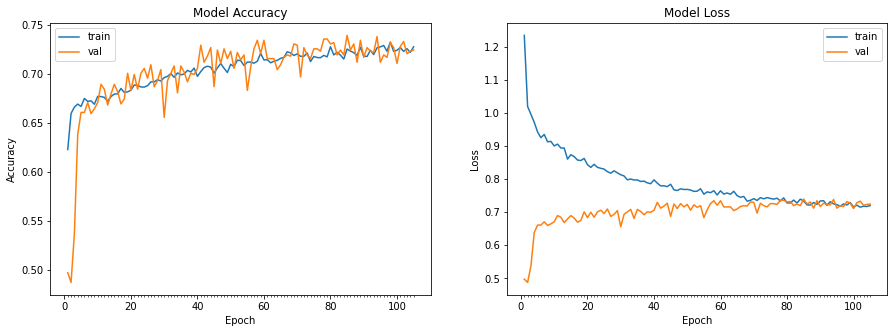

In [25]:
plot_model_history(history)

### **Evaluate the model on the validation and test data.**

Use the method **evaluate** of your keras Sequential model.

In [26]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 6ms/step - loss: 0.6985 - accuracy: 0.7304


[0.6985369920730591, 0.7304043769836426]

Make the prediction on the validation dataset. Plot the confusion matrix and check the missclassified count of each type.

In [27]:
# Predict the values from the validation dataset
Y_pred_classes1 = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = to_categorical(Y_pred_classes1, num_classes = 7,dtype='int')
# Convert validation observations to one hot vectors
Y_true = to_categorical(y_val, num_classes = 7,dtype='int')
# compute the confusion matrix
# CM = confusion_matrix (np.argmax(y_test,axis=1), np.argmax(Y_test_pred,axis=1))

confusion_mtx = confusion_matrix(np.argmax(y_val,axis=1), np.argmax(Y_pred_classes1,axis=1))

### **Plot the confusion matrix on the test dataset.**
Use the **plot_confusion_function** from the **exercise_functions** module. 

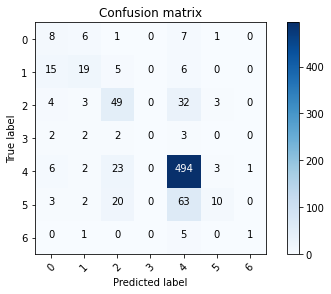

In [28]:
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Now, lets see which category has most incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

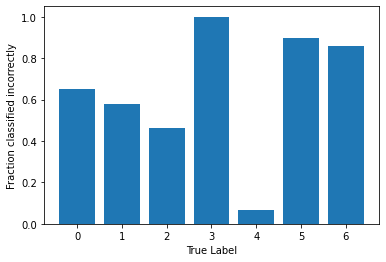

In [29]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

###When you are happy with your model, let it train longer, say for 100 to 150 epochs, or until it starts to overfit.
Then proceed to conclusions here below.


# Conclusion

Provide in your report analysis of the data. Give various distributions you could plot: the location of the mole, the patient's age and sex, the cancer type prevalence, ... Comment these distributions. What cancer is the most frequent one. Is the age distribution the same for all? ...

The Melanocytic nevi and vascular lesions has the same frequency at any age, and the nevi is the most frequent one.

### Conclude your report by answering to the following questions?

1. **Did your model converge?**

Yes, it converged, we can see that thanks to the plot of the loss and accuracy functions

2. **Did you not overfit?**

We can see no overfitting, we have no gap enlargment in the model loss and the validation is not decreasing.

3. **What was the accuracy you could reach?**

From the test set, we got the accuracy of 0.7304 and a model loss of 0.6985

4. **What were the most misclassified classes? What was the moest easily classified class?**

The most misclassified class is the number 3 (Dermatofibroma) with almost every one of them being misclassified and the 4 (melanocytic nevi) one is the best with almost no misclassifications. Which is makes sense, because the most frequent is the nevi and the least frequent one is the dermatofibroma. 

5. **Is your model competitive to human expert having ~77% accuracy? Any suggestion to improve the accuracy?**

The model can be considered competitive to humans because its accuracy is quite close to 77% (73%), and we can still improve the accuracy with bigger models, but due to computational time being larger, we didn't. We noticed that the data is quite unbalanced, so the most frequent cancer type will have a bigger impact onto the loss function. So we can improve the results by balancing the data or by using a weighted loss function.